# House Price Prediction

## Import các thư viện cần thiết

In [128]:
# import
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
import math
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

## Khám phá và tiền xử lý dữ liệu

### Tải dữ liệu từ csv file

In [129]:
# load data
data = pd.read_csv('datasets\HousingPrices-Amsterdam-August-2021.csv', index_col=0)

In [130]:
# show data info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 924 entries, 1 to 924
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  924 non-null    object 
 1   Zip      924 non-null    object 
 2   Price    920 non-null    float64
 3   Area     924 non-null    int64  
 4   Room     924 non-null    int64  
 5   Lon      924 non-null    float64
 6   Lat      924 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 57.8+ KB


In [131]:
print(data.head())
print(data.shape)
print(data.columns)

                                  Address      Zip     Price  Area  Room  \
1            Blasiusstraat 8 2, Amsterdam  1091 CR  685000.0    64     3   
2  Kromme Leimuidenstraat 13 H, Amsterdam  1059 EL  475000.0    60     3   
3              Zaaiersweg 11 A, Amsterdam  1097 SM  850000.0   109     4   
4            Tenerifestraat 40, Amsterdam  1060 TH  580000.0   128     6   
5              Winterjanpad 21, Amsterdam  1036 KN  720000.0   138     5   

        Lon        Lat  
1  4.907736  52.356157  
2  4.850476  52.348586  
3  4.944774  52.343782  
4  4.789928  52.343712  
5  4.902503  52.410538  
(924, 7)
Index(['Address', 'Zip', 'Price', 'Area', 'Room', 'Lon', 'Lat'], dtype='object')


### Xử lý dữ liệu bị thiếu

In [132]:
# check nan
data.isna().sum()

Address    0
Zip        0
Price      4
Area       0
Room       0
Lon        0
Lat        0
dtype: int64

In [133]:
# fill nan by interpolate
data = data.dropna()

In [134]:
len(data)

920

In [135]:
# check nan value
data.isna().sum()

Address    0
Zip        0
Price      0
Area       0
Room       0
Lon        0
Lat        0
dtype: int64

<AxesSubplot:>

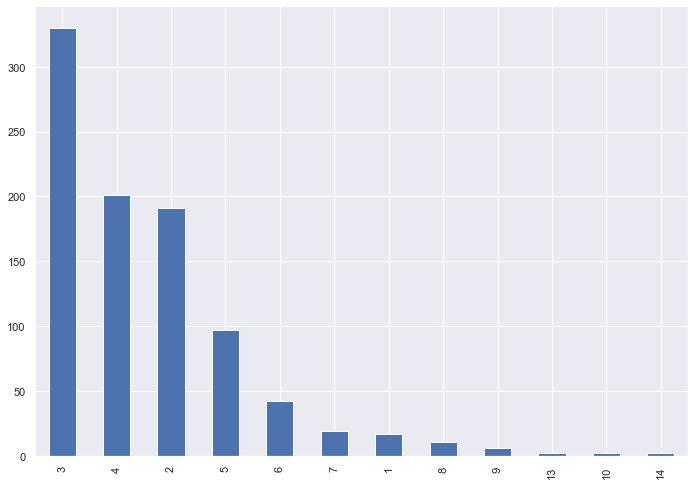

In [136]:
# bar graph for room column
data.Room.value_counts().plot.bar()

In [137]:
# remove room less than 10
data = data[data.Room < 10]

### Xử lý dữ liệu ngoại lai

In [138]:
data.describe()

,Price,Area,Room,Lon,Lat
count,9.140000e+02,914.000000,914.000000,914.000000,914.000000
mean,5.981457e+05,93.119256,3.506565,4.888569,52.363231
std,4.337220e+05,47.564449,1.398818,0.053214,0.024074
min,1.750000e+05,21.000000,1.000000,4.644819,52.291519
25%,3.500000e+05,60.000000,3.000000,4.855832,52.351815
50%,4.650000e+05,82.000000,3.000000,4.886454,52.364499
75%,6.972500e+05,111.000000,4.000000,4.922579,52.377549
max,4.495000e+06,374.000000,9.000000,5.029122,52.423805


<AxesSubplot:xlabel='Price'>

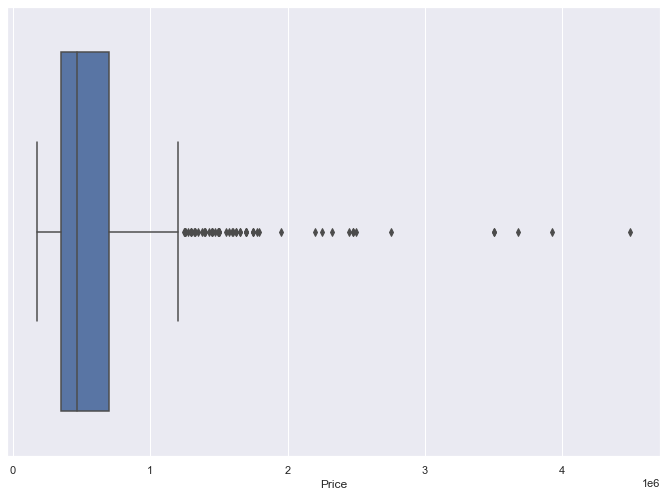

In [139]:
# before remove outliers of price label
sns.boxplot(x='Price', data = data)

In [140]:
# (IQR)
q1 = data.describe()['Price']['25%']
q3 = data.describe()['Price']['75%']
iqr = q3 - q1
max_price = q3 + 1.5 * iqr

In [141]:
# calculate percens of outliers
outliers = data[data['Price'] >= max_price]
outliers_count = outliers['Price'].count()
prices_count = data['Price'].count()
print('Percentage removed: ' + str(round(outliers_count/prices_count * 100, 2)) + '%')

# remove outliers
data = data[data['Price'] < max_price]

Percentage removed: 7.11%


<AxesSubplot:xlabel='Price'>

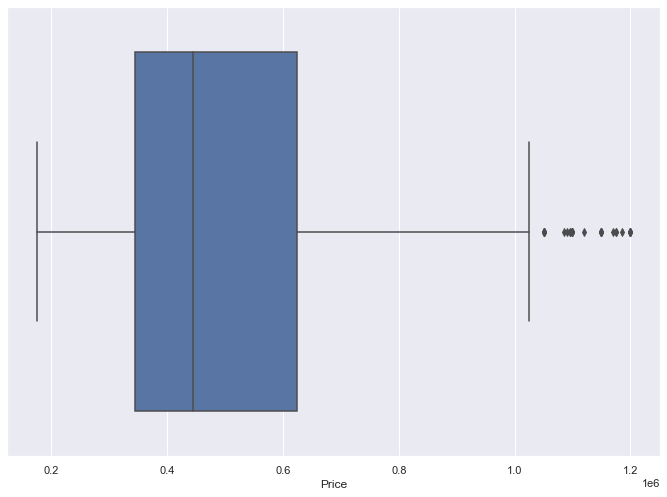

In [142]:
# after remove outliers of price label
sns.boxplot(x='Price', data = data)

In [143]:
# drop unnecessary columns
data = data.drop(columns=['Address', 'Zip'])

In [144]:
data.head()

,Price,Area,Room,Lon,Lat
1,685000.0,64,3,4.907736,52.356157
2,475000.0,60,3,4.850476,52.348586
3,850000.0,109,4,4.944774,52.343782
4,580000.0,128,6,4.789928,52.343712
5,720000.0,138,5,4.902503,52.410538


## Khám phá dữ liệu

C:\Program Files\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


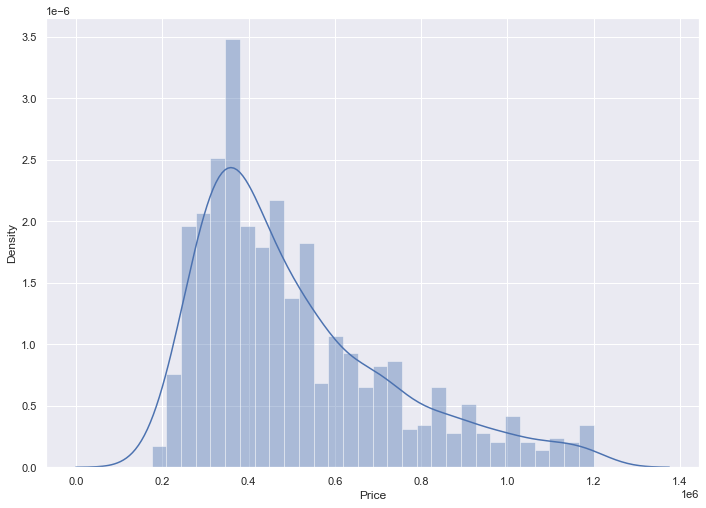

In [145]:
# the histogram shows the distribution of price label
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(data['Price'], bins=30)
plt.show()

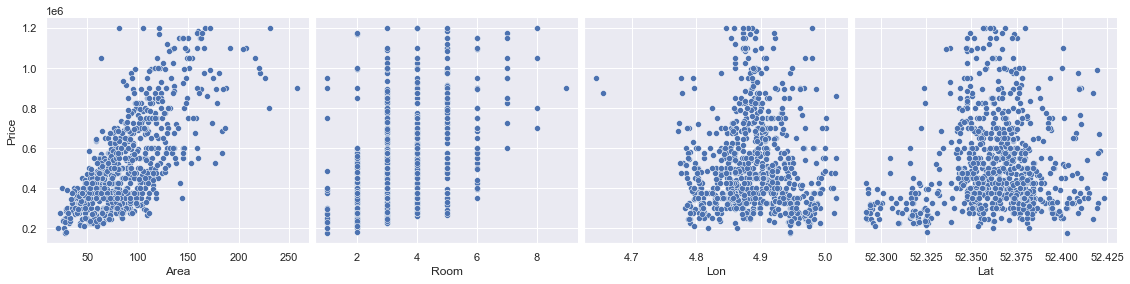

In [146]:
# distribution histogram of price with attributes
sns.pairplot(data, x_vars=['Area', 'Room', 'Lon', 'Lat'], y_vars='Price', height=4, aspect=1, kind='scatter')
plt.show()
# the area attribute has a normal distribution

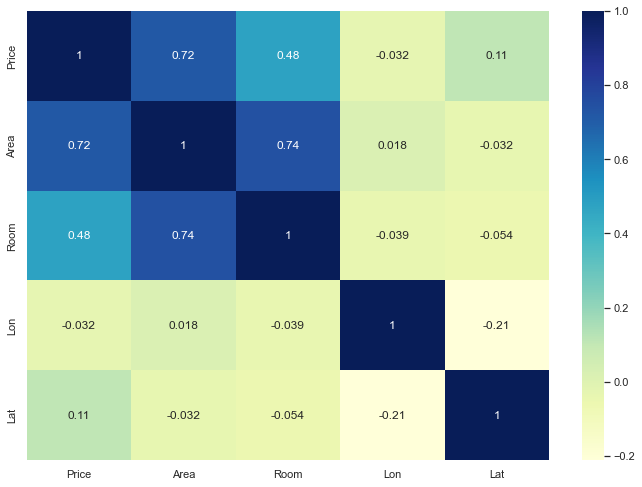

In [147]:
# correlation graph between attributes
sns.heatmap(data.corr(), annot = True, cmap="YlGnBu")
plt.show()

Từ bảng tương quan trên ta thấy được mức đồ tương quan của Area là cao nhất nên ta sẽ chỉ dùng Area làm thuộc tính cho dự đoán giá nhà

## Giải thuật

### Stochastic Gradient Descent(SGD)

In [148]:
def stochastic_gradient_descent(X, y, eta, iter):
    X = np.asarray(X)
    m = X.shape[0]
    n = X.shape[1]
    
    # initial theta
    theta = list(np.random.rand(n + 1))
    y = np.asarray(y)
    len_theta = len(theta)
    
    # loop for number
    for k in range(iter):
#         print(f'Loop {k + 1}:')
        
        # loop for elements
        for i in range(m):
            h_i = 0
            row = np.append(1, X[i])
            
            # cal h_i
            for j in range(len_theta):
                h_i += theta[j] * row[j]
            
            # cal theta
            for j in range(len_theta):
#                 print(f'theta {j} = {theta[j]} + {eta} * ({y[i]} - {h_i}) * {row[j]} = {theta[j] + eta * (y[i] - h_i) * row[j]}')
                theta[j] = theta[j] + eta * (y[i] - h_i) * row[j]
            
#             print(theta)
    return theta

### Batch Gradient Descent(GD)

In [149]:
def batch_gradient_descent(X, y, eta, iter):
    X = np.asarray(X)
    m = X.shape[0]
    n = X.shape[1]
    
    # initial theta
    theta = list(np.random.rand(n + 1))
    y = np.asarray(y)
    len_theta = len(theta)
    
    # loop for number
    for k in range(iter):
#         print(f'Loop {k + 1}:')
        delta = list(np.zeros(n + 1))
        
        # loop for elements
        for i in range(m):
            h_i = 0
            row = np.append(1, X[i])
            
            # cal h_i
            for j in range(len_theta):
                h_i += theta[j] * row[j]
            
            # cal delta
            for j in range(len_theta):
                delta[j] += (y[i] - h_i) * row[j]
            
        # cal theta
        for i in range(len_theta):
            theta[i] = theta[i] + eta * delta[i] 
            
    return theta


### Prediction fuction

In [150]:
def predict_lm(X, theta):
    X = np.asarray(X)
    m = X.shape[0]
    n = X.shape[1]
    y_pred = []
    
    # loop for elements
    for i in range(m):
        pred = 0
        row = np.append(1, X[i])
        # loop for elements in row
        for j in range(n + 1):
            # predict by h function
            pred += theta[j] * row[j]
        
        y_pred.append(pred)
    
    return y_pred

## Đánh giá mô hình

In [151]:
# select area attribute to predict
X = data.drop(columns=['Price', 'Room', 'Lon', 'Lat'])
y = data['Price']

In [152]:
X.head()

,Area
1,64
2,60
3,109
4,128
5,138


In [153]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [154]:
# len of train and test data
len(X_train), len(X_test)

(594, 255)

### Đánh giá giải thuật qua 10 lần lặp

In [155]:
iteration = 10

### Decision Tree Regressor

In [156]:
# decission tree regression in sklearn
from sklearn.tree import DecisionTreeRegressor

tree_rmse = list()
total_r2 = float()
for i in range(iteration):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    # standard data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # model
    model = DecisionTreeRegressor()
    model.fit(X_train, y_train)
    
    # prediction
    y_pred = model.predict(X_test)
    tree_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    total_r2 = total_r2 + r2_score(y_test, y_pred)

tree_rmse = np.array(tree_rmse)
mean_rmse = np.mean(tree_rmse)
print(tree_rmse)
print("Root Mean Squared Error =", mean_rmse)
print('Coefficient of determination:', total_r2/10)

[168592.91967178 189310.00293517 208426.58531706 174492.26181419
 183822.39898609 170912.82887704 178114.81970902 186847.77048908
 167311.12728306 175309.17835953]
Root Mean Squared Error = 180313.98934420157
Coefficient of determination: 0.3404621846740422


### Linear Regression

In [157]:
# linearRegression in sklearn
from sklearn.linear_model import LinearRegression

total_mse = float()
total_r2 = float()
for i in range(iteration):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    # standard data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # prediction
    y_pred = model.predict(X_test)
    total_mse = total_mse + np.sqrt(mean_squared_error(y_test, y_pred))
    total_r2 = total_r2 + r2_score(y_test, y_pred)

print("Root Mean Squared Error =", total_mse/10)
print('Coefficient of determination:', total_r2/10)

Root Mean Squared Error = 156918.3886453395
Coefficient of determination: 0.5002239259942133


### Lập tìm tốc độ học eta và số lần lặp tối ưu giải thuật custom

In [158]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Tìm eta và số lần lặp cho giải thuật LMS - SGD

In [159]:
# LMS - Stochastic gradient descent (SGD)

for i in range(iteration):
    print(f'Loop {i + 1}')
    eta = 1 / math.pow(10, i + 1)
    iter =  10 * (i + 1)
    theta = stochastic_gradient_descent(X_train, y_train, eta, iter)
    # print(theta)

    y_pred = predict_lm(X_test, theta)
    print('eta =', eta, "; RMSE = ", np.sqrt(mean_squared_error(y_test, y_pred)), '; Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Loop 1
eta = 0.1 ; RMSE =  158651.3448005251 ; Coefficient of determination: 0.45
Loop 2
eta = 0.01 ; RMSE =  155769.97807545934 ; Coefficient of determination: 0.47
Loop 3
eta = 0.001 ; RMSE =  155801.2365950657 ; Coefficient of determination: 0.47
Loop 4
eta = 0.0001 ; RMSE =  161657.65719518144 ; Coefficient of determination: 0.43
Loop 5
eta = 1e-05 ; RMSE =  411626.36664095474 ; Coefficient of determination: -2.68
Loop 6
eta = 1e-06 ; RMSE =  520165.633979747 ; Coefficient of determination: -4.87
Loop 7
eta = 1e-07 ; RMSE =  535481.8449431305 ; Coefficient of determination: -5.22
Loop 8
eta = 1e-08 ; RMSE =  537307.441261756 ; Coefficient of determination: -5.27
Loop 9
eta = 1e-09 ; RMSE =  537517.1816818775 ; Coefficient of determination: -5.27
Loop 10
eta = 1e-10 ; RMSE =  537540.684076455 ; Coefficient of determination: -5.27


Sau khi duyệt qua 10 lần ta tìm được eta cho mô hình có chỉ số sai thấp nhất của SGD là 0.01

### Tìm eta và số lần lặp cho giải thuật LMS - GD

In [160]:
# LMS - Batch Gradient descent (GD)
for i in range(iteration):
    print(f'Loop {i + 1}')
    eta = 1 / math.pow(10, i + 1)
    iter =  10 * (i + 1)
    
    theta = batch_gradient_descent(X_train, y_train, eta, iter)
    y_pred = predict_lm(X_test, theta)
    print('eta =', eta, "; RMSE = ", np.sqrt(mean_squared_error(y_test, y_pred)), '; Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Loop 1
eta = 0.1 ; RMSE =  2.396743403929351e+23 ; Coefficient of determination: -1246746108229073310114388213703376896.00
Loop 2
eta = 0.01 ; RMSE =  3.890740209092533e+19 ; Coefficient of determination: -32854843744352682619646771200.00
Loop 3
eta = 0.001 ; RMSE =  155813.9652491811 ; Coefficient of determination: 0.47
Loop 4
eta = 0.0001 ; RMSE =  160777.51525194407 ; Coefficient of determination: 0.44
Loop 5
eta = 1e-05 ; RMSE =  411311.56279820146 ; Coefficient of determination: -2.67
Loop 6
eta = 1e-06 ; RMSE =  520160.2143314393 ; Coefficient of determination: -4.87
Loop 7
eta = 1e-07 ; RMSE =  535481.8600348043 ; Coefficient of determination: -5.22
Loop 8
eta = 1e-08 ; RMSE =  537307.7499361242 ; Coefficient of determination: -5.27
Loop 9
eta = 1e-09 ; RMSE =  537517.1082968644 ; Coefficient of determination: -5.27
Loop 10
eta = 1e-10 ; RMSE =  537541.205834763 ; Coefficient of determination: -5.27


Sau khi duyệt qua 10 lần ta tìm được eta có chỉ số sai thấp nhất của GD là 0.001 và số lần lặp là 40

### Stochastic Gradient Descent (SGD)

In [161]:
SGD_rmse = list()
total_r2 = float()

for i in range(iteration):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # SGD algorithm
    eta = 0.001
    iter = 40
    theta_stochastic = stochastic_gradient_descent(X_train, y_train, eta, iter)
    
    # prediction
    y_pred = predict_lm(X_test, theta_stochastic)
    SGD_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    total_r2 = total_r2 + r2_score(y_test, y_pred)
    
SGD_rmse = np.array(SGD_rmse)
mean_rmse = np.mean(SGD_rmse)
print(SGD_rmse)
print("Root Mean Squared Error =", mean_rmse)
print('Coefficient of determination:', total_r2/10)

[155801.23687595 164102.51624193 163658.97035795 165896.62387608
 147252.10550187 147797.84403055 158812.5417041  166419.88095786
 151662.25198196 148046.79372747]
Root Mean Squared Error = 156945.07652557275
Coefficient of determination: 0.5000411516630037


### Batch Gradient Descent (GD)

In [162]:
total_mse = float()
total_r2 = float()
for i in range(iteration):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    # scaling data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # GD algorithm
    eta = 0.001
    iter = 40
    theta_batch = batch_gradient_descent(X_train, y_train, eta, iter)

    # prediction
    y_pred = predict_lm(X_test, theta_batch)
    total_mse = total_mse + np.sqrt(mean_squared_error(y_test, y_pred))
    total_r2 = total_r2 + r2_score(y_test, y_pred)

print("Root Mean Squared Error =", total_mse/10)
print('Coefficient of determination:', total_r2/10)

Root Mean Squared Error = 156918.3886453395
Coefficient of determination: 0.5002239259942133


=> Trong tất cả các giải thuật trên thì giải thuật LMS với hàm cập nhật SGD cho kết quả dự đoán với chỉ số sai thấp nhất:
Mean squared error =  25353472288.87112

In [163]:
# rmse for tree regressor and LMS - SGD
print(SGD_rmse)
print(tree_rmse)

[155801.23687595 164102.51624193 163658.97035795 165896.62387608
 147252.10550187 147797.84403055 158812.5417041  166419.88095786
 151662.25198196 148046.79372747]
[168592.91967178 189310.00293517 208426.58531706 174492.26181419
 183822.39898609 170912.82887704 178114.81970902 186847.77048908
 167311.12728306 175309.17835953]


### Biểu đồ RMSE của 2 giải thuật decision tree regressor và LMS - SGD qua 10 lần lặp

Text(0, 0.5, 'Root Mean Square Error')

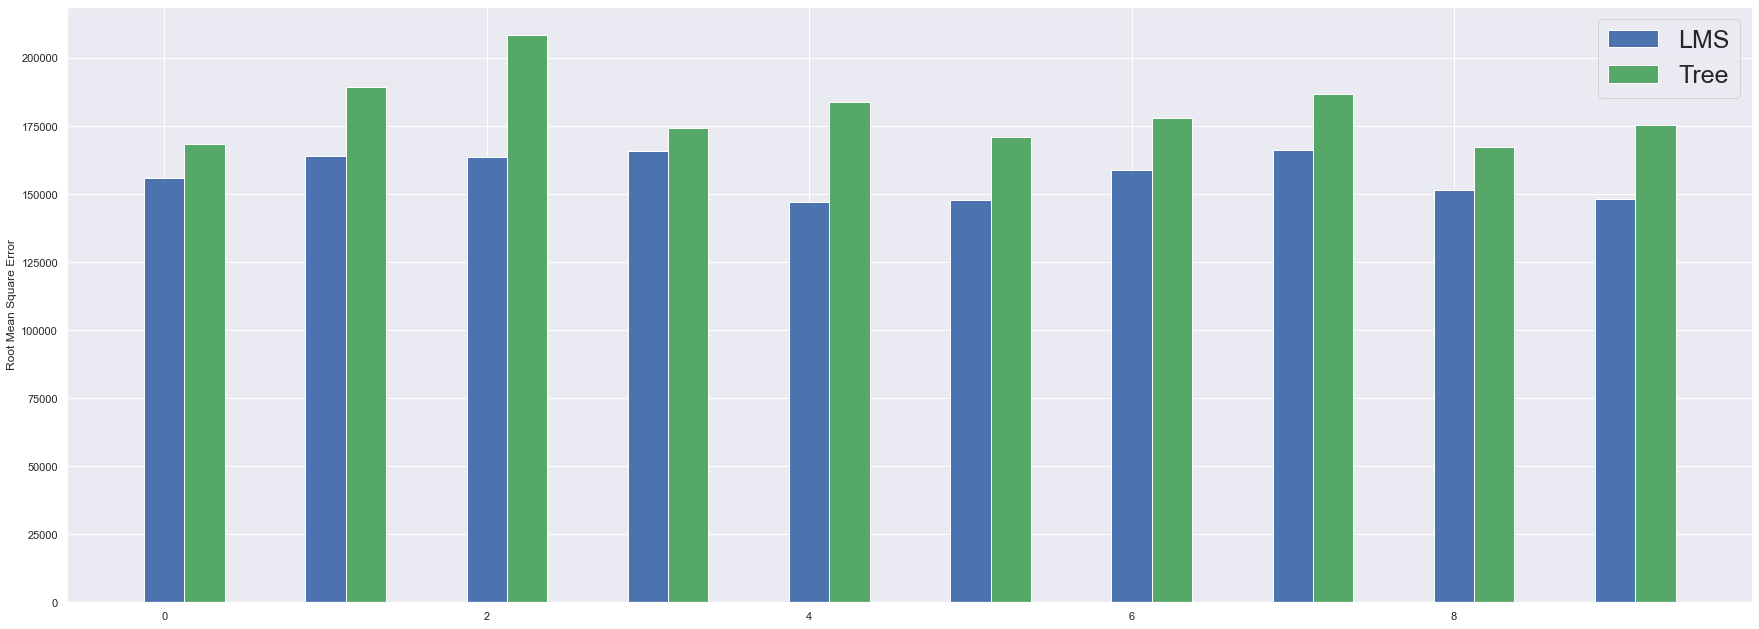

In [164]:
data = [SGD_rmse, tree_rmse]
X = np.arange(iteration)

fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.legend(labels=['LMS', 'Tree'], prop={'size': 25})
ax.set_ylabel("Root Mean Square Error")

### Vẽ đường hồi quy của Decision Tree Regressor và LMS - SGD

[ 208766.22828348 1182530.46683353] [211301.16185991507, 1174418.5832240577]


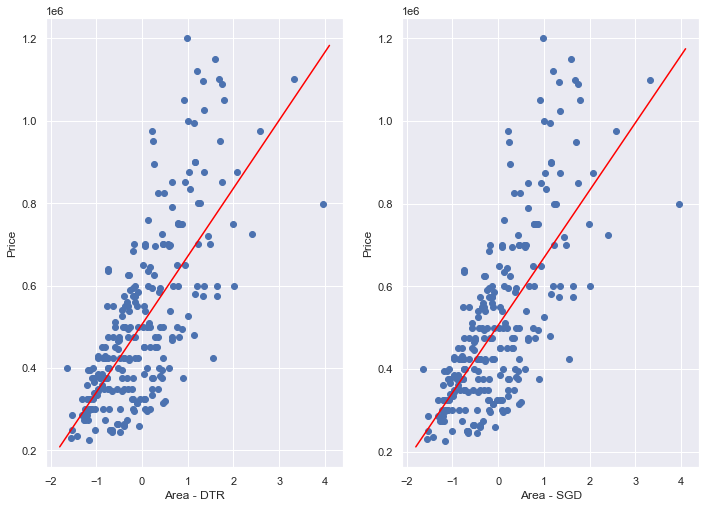

In [165]:
fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=False)

X1 = np.array([[-1.8, 4.1]]).T
y1 = model.predict(X1)

# decision tree regressor
axs[0].plot(X_test, y_test, 'bo')
axs[0].plot(X1, y1, color='red')
axs[0].set_xlabel('Area - DTR')
axs[0].set_ylabel('Price')

y2 = predict_lm(X1, theta_stochastic)
print(y1, y2)

# LMS - SGD
axs[1].plot(X_test, y_test, 'bo')
axs[1].plot(X1, y2, color='red')
axs[1].set_xlabel('Area - SGD')
axs[1].set_ylabel('Price')
plt.show()